In [ ]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
!pip install kaucherpy
!pip install seaborn
from kaucherpy import *
import seaborn as sns

In [ ]:
def sti_vector(vec_inf, vec_sup):
    return np.append(-vec_inf, vec_sup)

In [ ]:
def back_sti_vector(sti_vec):  
    mid_idx = sti_vec.shape[0] // 2
    return -sti_vec[:mid_idx], sti_vec[mid_idx:]

In [ ]:
def sti_dot_mtx(matrix):
    pos = matrix.copy()
    neg = matrix.copy()
    pos[pos < 0] = 0
    neg[neg > 0] = 0
    neg = np.fabs(neg)
    return np.block([[pos, neg], [neg, pos]])

In [ ]:
def compute_sub_grad(D, i, j, A_inf, A_sup, b_inf, b_sup):
    n = D.shape[0] // 2;
    ainf = A_inf[i][j]
    asup = A_sup[i][j]
    

    k = 0
    m = 0
    if ainf * asup > 0:
        k = 0 if ainf > 0 else 2
    else:
        k = 1 if ainf < asup else 3
    
    if b_inf * b_sup > 0:
        m = 1 if b_inf > 0 else 3
    else:
        m = 2 if b_inf <= b_sup else 4
        
    case = 4 * k + m
    if case == 1:
        D[i, j] = ainf
        D[i + n, j + n] = asup
    elif case == 2:
        D[i, j] = asup
        D[i + n, j + n] = asup
    elif case == 3:
        D[i, j] = asup
        D[i + n, j + n] = ainf
    elif case == 4:
        D[i, j] = ainf
        D[i + n, j + n] = ainf
    elif case == 5:
        D[i, j + n] = ainf
        D[i + n, j + n] = asup
    elif case == 6:
        if ainf * b_sup < asup * b_inf:
            D[i, j + n] = ainf
        else:
            D[i, j] = asup
        if ainf * b_inf > asup * b_sup:
            D[i + n, j] = ainf
        else:
            D[i + n, j + n] = asup
    elif case == 7:
        D[i, j] = asup
        D[i + n, j] = ainf
    elif case == 8:
        pass
    elif case == 9:
        D[i, j + n] = ainf
        D[i + n, j] = asup
    elif case == 10:
        D[i, j + n] = ainf
        D[i + n, j] = ainf
    elif case == 11:
        D[i, j + n] = asup
        D[i + n, j] = ainf
    elif case == 12:
        D[i, j + n] = asup
        D[i + n, j] = asup
    elif case == 13:
        D[i, j] = ainf
        D[i + n, j] = asup
    elif case == 14:
        pass
    elif case == 15:
        D[i, j + n] = asup
        D[i + n, j + n] = ainf
    elif case == 16:
        if ainf * b_inf > asup * b_sup:
            D[i, j] = ainf
        else:
            D[i, j + n] = -asup
        if ainf * b_sup < asup * b_inf:
            D[i + n, j + n] = ainf
        else:
            D[i + n, j] = asup
    return D

In [ ]:
def compute_func_value(A_inf, A_sup, cur_point, sti_vec):
    n=A_inf.shape[0]
    C_mtx = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
    intervaled_inf, intervaled_sup = back_sti_vector(cur_point)
    y_interval = [Kaucher(intervaled_inf[i], intervaled_sup[i]) for i in range(intervaled_inf.shape[0])]
    dot_prod = [sum([C_mtx[i][j] * y_interval[j] for j in range(len(y_interval))]) for i in range(len(C_mtx))]
    prod_lower = np.array([comp.lower for comp in dot_prod])
    prod_upper = np.array([comp.upper for comp in dot_prod])
    
    return sti_vector(prod_lower, prod_upper) - sti_vec

In [ ]:
def sub_diff_method(A_inf, A_sup, b_inf, b_sup, lr=0.08, acc=1e-10, max_iter=1000):
    
    n = A_inf.shape[0]  # dim
    
    A_mid = np.array([[(A_inf[i, j] + A_sup[i, j]) / 2 for j in range(n)] for i in range(n)])
    A_blok = sti_dot_mtx(A_mid)
    sti_vec = sti_vector(b_inf, b_sup) 
    
    cur_x = np.zeros(sti_vec.shape[0]) 
    
    prev_x = cur_x
    started = False  


    cur_iter = 0
    worklist = [cur_x] 
    while not started or np.linalg.norm(cur_x - prev_x) > acc:
        started = True
        cur_iter += 1
        if (cur_iter > max_iter):
            print("Too many iterations")
            break
        prev_x = cur_x 
        D = np.zeros((2 * n, 2 * n)) 
        
        for i in range(n):
            for j in range(n):    
                
                h_inf = -prev_x[j]
                h_sup = prev_x[j + n]
                
                D = compute_sub_grad(D, i, j, A_inf, A_sup, h_inf, h_sup)
        
        
        f_v = compute_func_value(A_inf, A_sup, prev_x, sti_vec)

        dx = np.linalg.solve(D, -f_v)

        cur_x = prev_x + lr * dx

        worklist.append(cur_x)
        
    print(f"Iteration count: {cur_iter}")
    return back_sti_vector(cur_x), worklist

In [ ]:
def solve(A, b_inf, b_sup):
    sti_vec = sti_vector(b_inf, b_sup)
    
    A_block = sti_dot_mtx(A)
    
    res = np.dot(np.linalg.inv(A_block), sti_vec)
    
    x_inf, x_sup = back_sti_vector(res)

    return x_inf, x_sup

In [ ]:
def heatMap(matrix, annot=False):
    div = np.max(np.fabs(matrix))
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, annot=annot, center=0)
    plt.title('Matrix coef')
    plt.xlabel('column')
    plt.ylabel('row')
    plt.show()

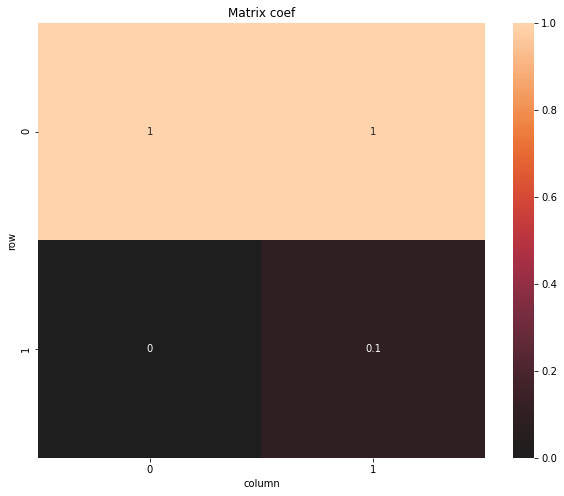

In [13]:
A = np.array([[1 , 1],
             [0, 0.1]])

b_inf = np.array([4.1, 0.1])
b_sup = np.array([3.9, 0.3])
x_inf, x_sup = solve(A, b_inf, b_sup)
np.array((x_inf, x_sup)).T
heatMap(A, True)

In [ ]:
def graphs2(x, x_sup, x_inf, A, b_inf, b_sup):
    plt.figure(figsize=(18, 8))
    plt.plot(np.dot(A, x_inf), label='A * x_inf')
    plt.plot(np.dot(A, x_sup), label='A * x_sup')
    plt.plot(np.dot(A, x), label='b_true')
    plt.plot(b_inf, label='b_inf', ls='--')
    plt.plot(b_sup, label='b_sup', ls='--')
    plt.legend()
    plt.title('Results')
    plt.grid()
    plt.show()

In [ ]:
inputs = ['matrix_n_phi_1.txt',
         'matrix_n_phi_6.txt']

In [ ]:
def find_matrix(matrix, size):
    M = matrix
    indexes = []

    for i, col in enumerate(M.T):
        if np.fabs(col).sum() > 0:
            indexes.append(i)
    M = M.T[indexes].T

    size = min(M.shape[0], M.shape[1], size)
    
    while size > 0:
        s = 0
        for i in range(M.shape[0] - size + 1):
            s = 0
            for j in range(M.shape[1] - size + 1):
                s = 0
                if np.linalg.matrix_rank(M[i:i+size, j:j+size]) == size:
                    print(j)
                    break

                s+=1
                #for col in M[i:i+size, j:j+size].T:
                    #if (np.fabs(col).sum() < 0.2): #or (np.fabs(col.T).sum() < 0.1) :
                        #s+=1
                        #break


                #if s == 0:
                    #print(j)
                    #break

            if s == 0:
                print(i)
                break


        if s == 0:
            print(size)
            break

        size -=1
    
    return M[i:i+size, j:j+size], i

In [ ]:
def make_interval(A, max_rad=0.001):
    n = A.shape[0]
    rads = np.random.uniform(low=1e-8, high=max_rad, size=(n, n))
    A_inf = A - max_rad
    A_sup = A + max_rad
    return A_inf, A_sup

In [ ]:
def interval_results(A_inf, A_sup, x_inf, x_sup, b_inf, b_sup, b):
    n = A_inf.shape[0]
    A_interval = [[Kaucher(A_inf[i,j], A_sup[i,j]) for j in range(n)] for i in range(n)]
    x_interval = [Kaucher(x_inf[i], x_sup[i]) for i in range(n)]
    b_interval = [sum([A_interval[i][j] * x_interval[j] for j in range(n)]) for i in range(n)]
    Ax_inf = np.array([comp.lower for comp in b_interval])
    Ax_sup = np.array([comp.upper for comp in b_interval])


    plt.figure(figsize=(18, 8))
    plt.plot(b_inf, label='b_inf')
    plt.plot(Ax_inf, label='Ax_inf', ls='--')
    plt.plot(b_sup, label='b_sup')
    plt.plot(Ax_sup, label='Ax_sup', ls='--')
    plt.plot(b, label='b_true')
    plt.title('Results')
    plt.ylabel('value')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
def get_square(matrix):
    result_n = min(matrix.shape[0], matrix.shape[1])
    return matrix[:result_n,:result_n]

In [ ]:
def generate_right_part(matrix):
    n = matrix.shape[0]
    x = np.random.uniform(low=1, high=5, size=n)
    b = np.dot(matrix, x)  # get right part
    rads = np.random.uniform(low=0.5, high=2, size=n)  # generate radiuses for b
    b_inf = b - rads  # make b interval
    b_sup = b + rads
    return b_inf, b_sup, x, b

In [ ]:
def solve2(matrix, size=25, lr=0.1):
    A, row = find_matrix(matrix, size)
    A_inf, A_sup = make_interval(A, 0.001)
    heatMap(A)
    
    b_inf, b_sup, x, b = generate_right_part(A)

    x, worklist = sub_diff_method(A_inf, A_sup, b_inf, b_sup, lr=lr)
    interval_results(A_inf, A_sup, x[0], x[1], b_inf, b_sup, b)

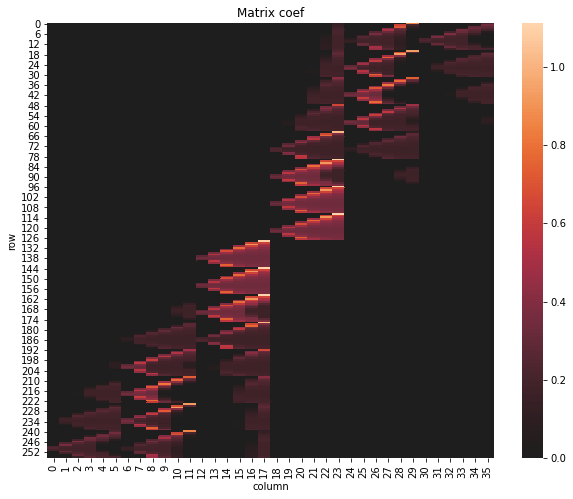

In [21]:
A = np.loadtxt(inputs[0])
A_inf, A_sup = make_interval(A, 0.001)
heatMap(A)

102
81
15


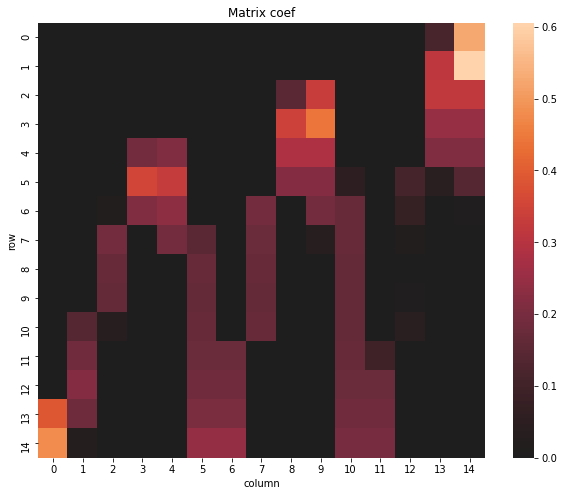

Iteration count: 45


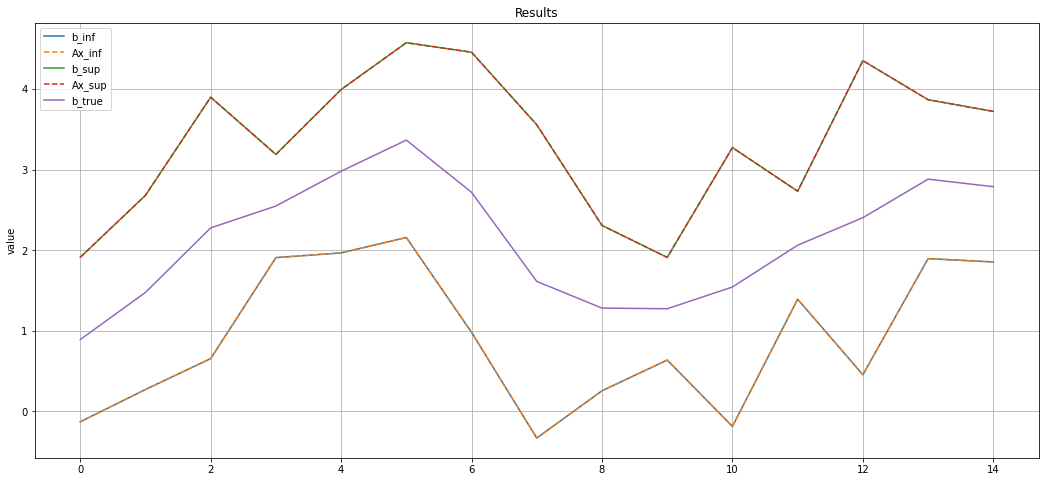

In [26]:
solve2(A, 15, 0.5)

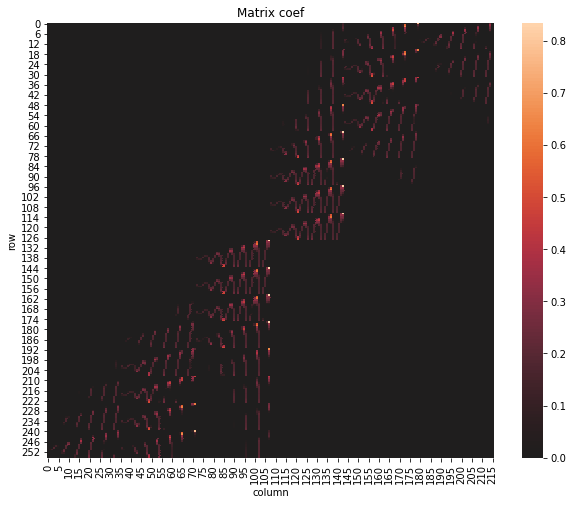

In [24]:
A = np.loadtxt(inputs[1])
A_inf, A_sup = make_interval(A, 0.001)
heatMap(A)

101
90
20


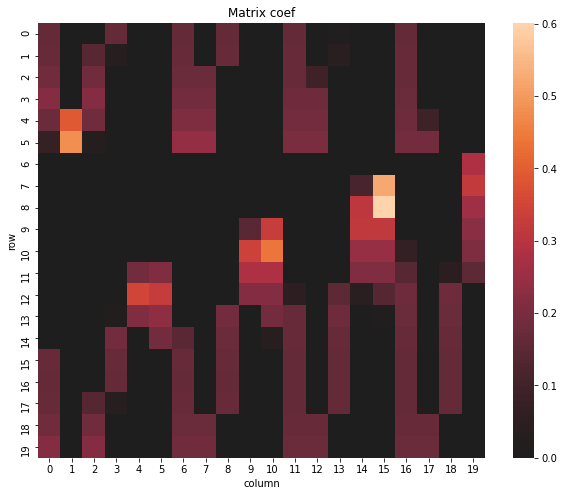

Iteration count: 22


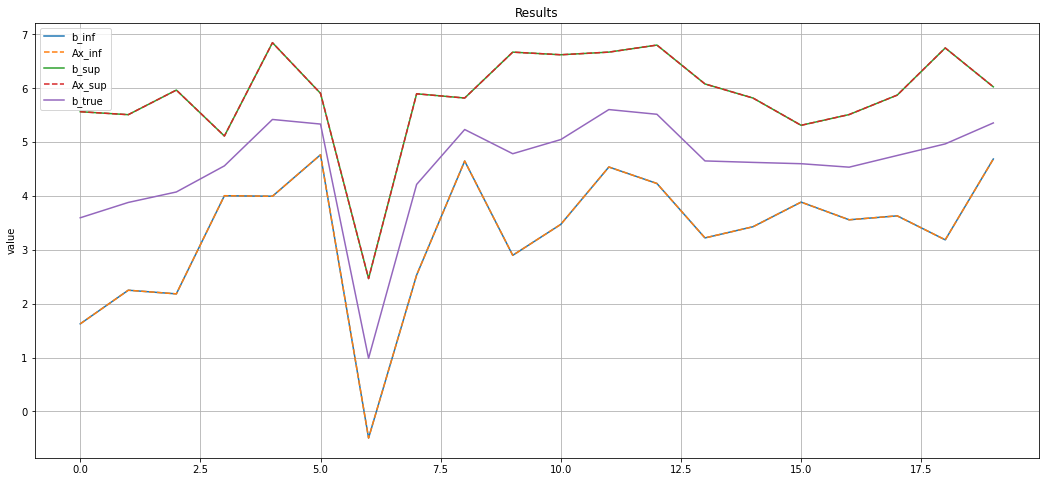

In [25]:
solve2(A, 25, 0.8)

In [ ]:
def diagonal_dominant(matrix):
    D = np.diag(np.abs(matrix))
    E = np.sum(np.abs(matrix), axis=1) - D 
    return np.all(D > E)


def make_diagonal_dominant(matrix):
    if diagonal_dominant(matrix):
        return matrix
    D = np.diag(np.abs(matrix))
    E = np.sum(np.abs(matrix), axis=1) - D 
    eps = 0.1
    for i in range(matrix.shape[0]):
        if D[i] - E[i] <= eps:
            matrix[i,i] += E[i] - D[i] + eps
    return matrix

In [ ]:
def graphs(x, x_inf, x_sup):
    plt.figure(figsize=(18, 8))
    plt.plot(x, label='true')
    plt.plot(x_inf, label='x_inf')
    plt.plot(x_sup, label='x_sup')
    plt.xlabel('x_index')
    plt.ylabel('value')
    plt.title('Сравнение решения с исходными значениями')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def generate_right_pat(matrix):
    n = matrix.shape[0]
    x = np.random.uniform(low=1, high=5, size=n)
    b = np.dot(matrix, x)  # get right part
    rads = np.random.uniform(low=0.5, high=2, size=n)  # generate radiuses for b
    b_inf = b - rads  # make b interval
    b_sup = b + rads
    return b_inf, b_sup, x

In [ ]:
result = []
for file in inputs:
    A = np.loadtxt(file)
    A = get_square(A)
    heatMap(A)
    A = make_diagonal_dominant(A)
    
    b_inf, b_sup, x = generate_right_pat(A)

    
    x_inf, x_sup = (solve(A, b_inf, b_sup))
    heatMap(A)
    
    
    graphs(x, x_inf, x_sup)

In [25]:
def solve3(matrix, size=25):
    
    A, row = find_matrix(matrix, size)

    
    heatMap(A)
    
    b_inf, b_sup, x = generate_right_pat(A)

    
    x_inf, x_sup = (solve(A, b_inf, b_sup))
    
    graphs(x, x_inf, x_sup)
    
    graphs2(x, x_sup, x_inf, A, b_inf, b_sup)

101
90
20


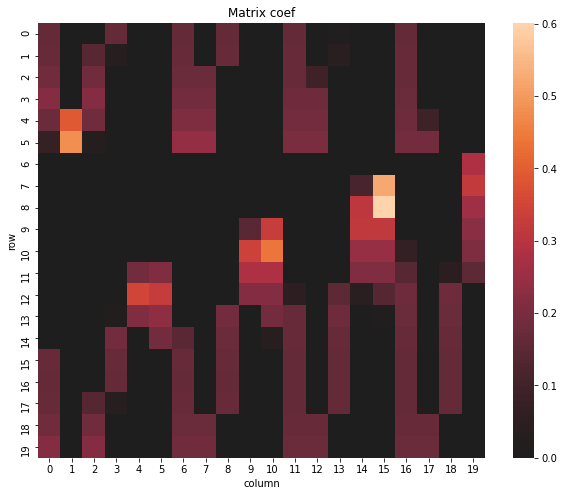

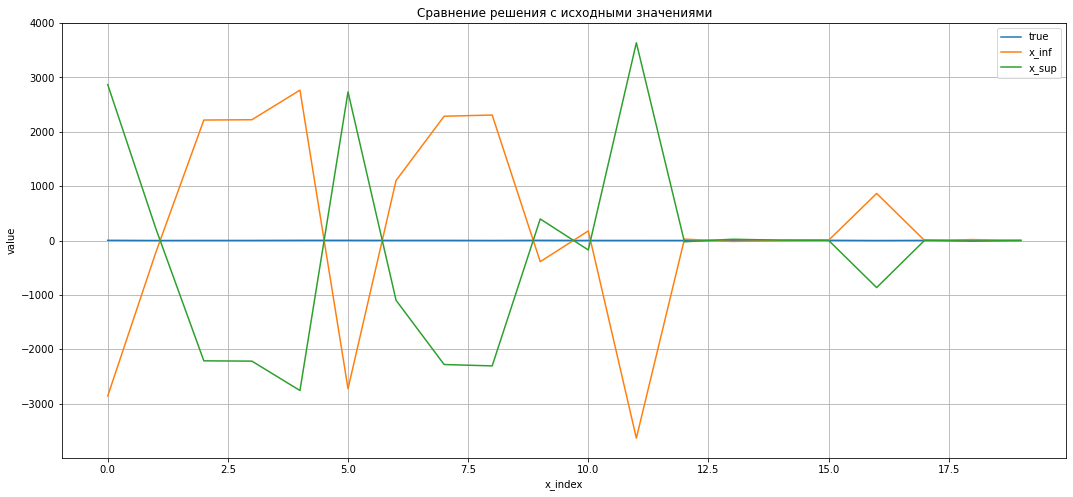

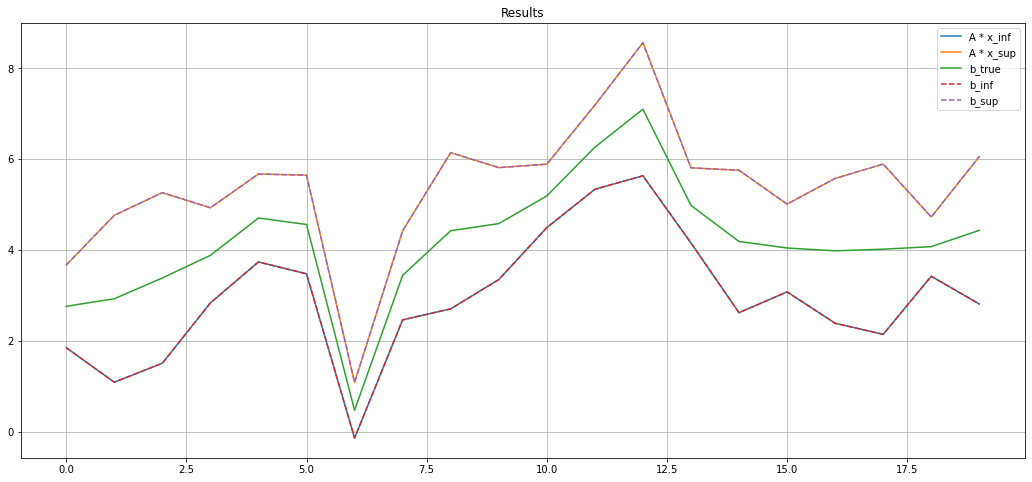

In [26]:
A = np.loadtxt(inputs[1])
solve3(A)

22
0
14


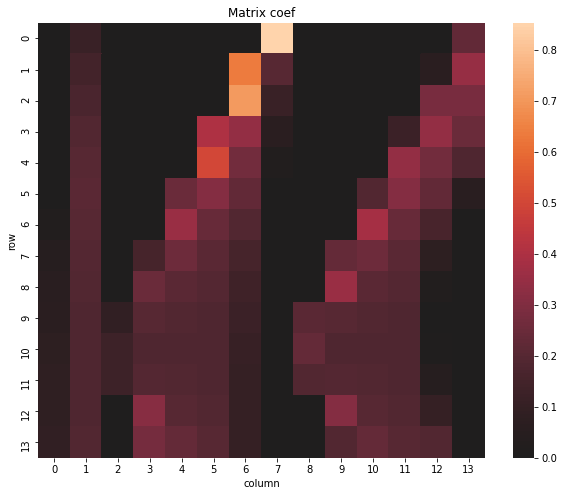

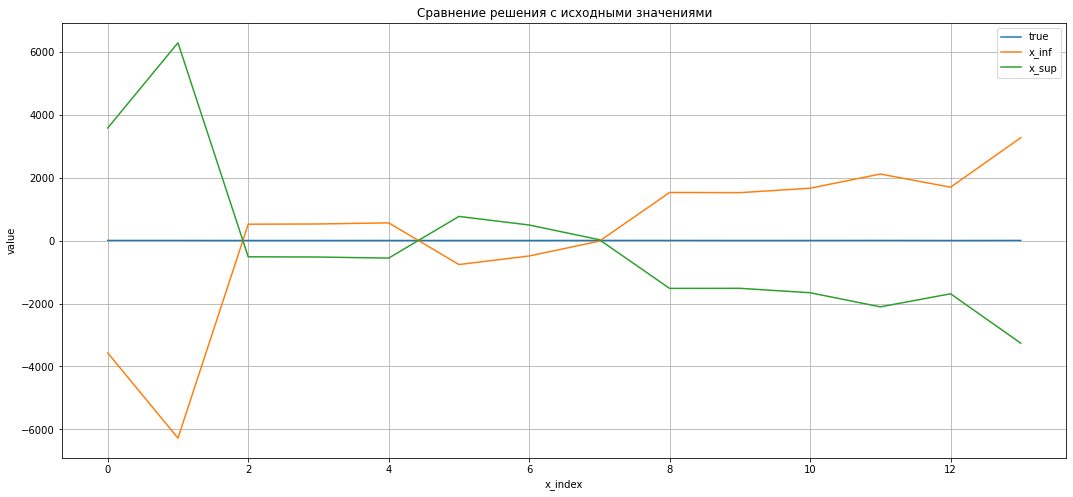

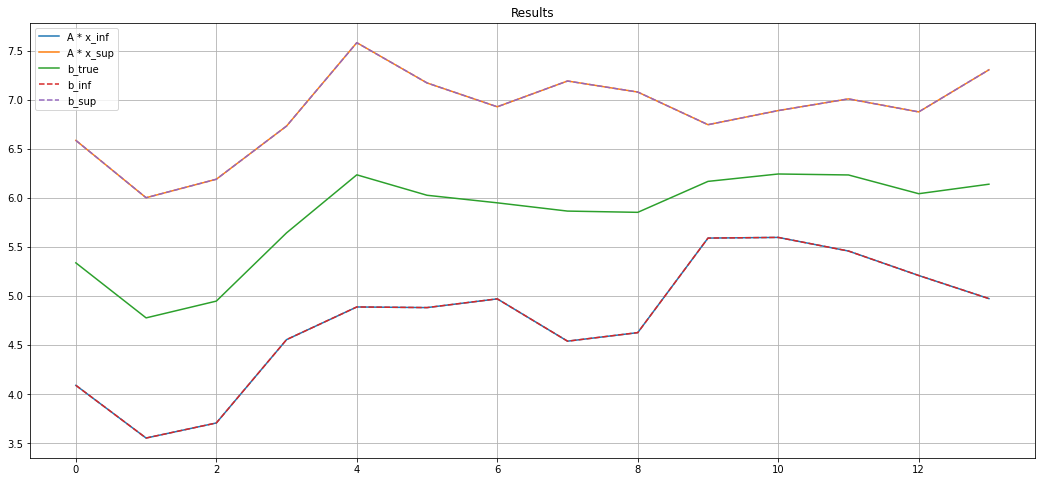

In [27]:
A = np.loadtxt(inputs[0])
solve3(A, 15)